# Literature Drug Response

In [1]:
import sys 
%reload_ext rpy2.ipython


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)
import sklearn
from sklearn.metrics import silhouette_score
import matplotlib as mpl

In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3

## Drug Treatments in Primary Samples

In [2]:
# Load compiled data on composition changes
primary = pd.read_csv("Data/Fig5_Literature_DrugResponse/Drug_Primary_pvalues.csv", index_col = 0)

# Get -log(pvalues) and treatment information
primary['logPval_dir'] = np.where(primary['scores'] < 0, np.log(primary['pvals']), -np.log(primary['pvals']))
primary['Treatment'] = np.where(primary['Cohort']=="Primary", primary['Drug'], primary['Drug'] + " [" + primary['Cohort'].str.replace('Primary ', '') + "]")

In [3]:
# Re-order cell types
primary['CellType'] = primary['names'].astype('category').cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])

# New matrices with log p-values and uncorrected p-values
primary_logpval_dir = primary.pivot(index='Treatment', columns='names', values='logPval_dir')\
        [['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like', 'PC2']].T
primary_pvalue = primary.pivot(index='Treatment', columns='names', values='pvals')\
        [['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like', 'PC2']].T

# Order drugs in matrices by first PC
primary_drug_clust = ad.AnnData((primary_pvalue < 0.05) * primary_logpval_dir).T
sc.pp.pca(primary_drug_clust, n_comps=1)
primary_drug_clust.obs['pc1'] = primary_drug_clust.obsm['X_pca'].flatten()
primary_logpval_dir = primary_logpval_dir[primary_drug_clust.obs.sort_values('pc1', ascending=False).index.values]
primary_pvalue = primary_pvalue[primary_drug_clust.obs.sort_values('pc1', ascending=False).index.values]

## Drug Treatments in Cell Lines

In [4]:
cell_lines = pd.read_csv("Data/Fig5_Literature_DrugResponse/Drug_Cell_Line_pvalues.csv", index_col = 0)

# Get -log(pvalues) and treatment information
cell_lines['logPval_dir'] = np.where(cell_lines['scores'] < 0, np.log(cell_lines['pvals']), -np.log(cell_lines['pvals']))
cell_lines['Treatment'] = np.where(cell_lines['Cohort']=="Primary", cell_lines['Drug'], cell_lines['Drug'] + " [" + cell_lines['Cohort'].str.replace('Primary ', '') + "]")

In [5]:
# Re-order cell types
cell_lines['CellType'] = cell_lines['names'].astype('category').cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])

# New matrices with log p-values and uncorrected p-values
cell_lines_logpval_dir = cell_lines.pivot(index='Treatment', columns='names', values='logPval_dir')\
        [['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like', 'PC2']].T
cell_lines_pvalue = cell_lines.pivot(index='Treatment', columns='names', values='pvals')\
        [['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like', 'PC2']].T


In [6]:
# Order drugs in matrices by first PC
cell_lines_drug_clust = ad.AnnData((cell_lines_pvalue < 0.05) * cell_lines_logpval_dir).T
sc.pp.pca(cell_lines_drug_clust, n_comps=1)
cell_lines_drug_clust.obs['pc1'] = cell_lines_drug_clust.obsm['X_pca'].flatten()
cell_lines_logpval_dir = cell_lines_logpval_dir[cell_lines_drug_clust.obs.sort_values('pc1', ascending=False).index.values]
cell_lines_pvalue = cell_lines_pvalue[cell_lines_drug_clust.obs.sort_values('pc1', ascending=False).index.values]

# Combined Cell Line and Primary

In [7]:
# Concatenated directional log p-values from primary and cell line treatments 
cat_logpval_dir = primary_logpval_dir.join(cell_lines_logpval_dir)
cat_logpval_dir = cat_logpval_dir.fillna(0)

# Concatenated uncorrected p-values from primary and cell line treatments 
cat_pvalues = primary_pvalue.join(cell_lines_pvalue)

# Directional log pvalues filtered for significant changes 
cat_lpr_sig = (cat_logpval_dir * (cat_pvalues < 0.05)).T
cat_lpr_sig.columns = cat_lpr_sig.columns+'-sig'

In [9]:
cat_pvalues < 0.05

Treatment,TRC105,JQ1 [MLL-r],5-Aza [TET2mut],AlCAr,5-Aza + Crenolanib [FLT3-ITDmut],Crenolanib [FLT3-ITDmut],KPT330,JQ1 + CDKI-73 [MLL-r],5-Aza [FLT3-ITDmut],CDKI-73 [MLL-r],...,AC-4-130 [MV4-11],BAY155 [MV411],BSJ (CDK6 only) [MV4-11],GSK3186000A [MOLM-13],EPZ5676 [OCIAML3],BAY1251152 [OCIAML2],BAY1251152 [NOMO1],Dexamathasone [MV4-11],BAY1251152 [OCIAML3],BAY155 [OCIAML2]
names,,,,,,,,,,,,,,,,,,,,,
LSPC-Quiescent,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,True,False,False,True
LSPC-Primed,True,True,False,True,False,False,False,False,False,False,...,True,False,True,False,False,True,False,True,False,True
LSPC-Cycle,False,False,False,True,True,True,True,False,False,False,...,True,True,True,True,True,False,True,True,True,True
GMP-like,True,True,False,True,False,False,False,False,False,True,...,True,True,False,True,False,False,False,True,False,True
ProMono-like,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,True,True,False,False,True,False
Mono-like,True,True,True,True,False,False,False,False,False,False,...,False,True,False,True,False,True,True,False,True,True
cDC-like,True,False,True,True,False,False,False,True,False,False,...,True,True,False,False,False,False,False,True,True,False
PC2,True,True,False,True,False,False,False,False,False,False,...,True,True,True,False,True,True,True,False,True,False


## Clean Cell Line Annotations

In [10]:
# Standardize cell line names 
anno = primary[['Cohort', 'Drug', 'Test', 'Target', 'Treatment']].set_index('Treatment').drop_duplicates().\
    append(cell_lines[['Cohort', 'Drug', 'Test', 'Target', 'Treatment']].set_index('Treatment').drop_duplicates())
anno['Cohort'] = anno['Cohort'].str.replace('OCIAML', 'OCI-AML').str.replace('THP1', 'THP-1').str.replace('Kasumi1', 'Kasumi-1')\
    .str.replace('NOMO1', 'NOMO-1').str.replace('KASUMI', 'Kasumi').str.replace('MV411', 'MV4-11').str.replace('MOLM14', 'MOLM-14').str.replace('ML2','ML-2')\
    .str.replace('HL60', 'HL-60').str.replace('NB4', 'NB-4').str.replace('U937', 'U-937').str.replace('K562', 'K-562').str.replace('KG1', 'KG-1').str.replace('MV-4', 'MV4')\
    .str.replace('MOLM13', 'MOLM-13').str.replace('MV4-11.*', 'MV4-11').str.replace('MOLM-13.*', 'MOLM-13').str.replace('OCI-AML3.*', 'OCI-AML3').str.replace('AML-2', 'AML2')
anno['Cohort'] = anno['Cohort'].astype('str')

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [12]:
# Integrate genomic information
genomics = pd.read_csv("Data/Fig5_Literature_DrugResponse/Cell_Line_Genomics.csv").rename(columns={'Cell_Line':'Cohort'})
genomics['Cohort'] = genomics['Cohort'].astype('str')
anno = anno.reset_index().merge(genomics, how='left', on='Cohort').set_index('Treatment')

In [46]:
composition = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
composition.obs['PC2'] = cat_logpval_dir.loc['PC2']
composition.obs = composition.obs.join(anno)

# Check for differentiation
composition.obs['Differentiation'] = np.where(composition.obs['PC2'] >= 3, 'Differentiation', 'No')

# Filter for significant changes
composition.obs["Sig Changes"] = (cat_pvalues < 0.05).sum()
composition.obs['qLSPC_pLSPC_sigdown'] = (cat_logpval_dir.loc[['LSPC-Quiescent', 'LSPC-Primed'],] <= -3).sum()
composition.obs['qLSPC_sigdown'] = (cat_logpval_dir.loc[['LSPC-Quiescent'],] <= -3).sum()
composition.obs['pLSPC_sigdown'] = (cat_logpval_dir.loc[['LSPC-Primed'],] <= -3).sum()
composition.obs['GMP_sigdown'] = (cat_logpval_dir.loc[['GMP-like'],] <= -3).sum()
composition = composition[composition.obs['Sig Changes'] > 0]

In [47]:
composition[composition.obs['Differentiation'] == 'Differentiation'].obs['GMP_sigdown'].value_counts()

1    53
0    24
Name: GMP_sigdown, dtype: int64

In [48]:
composition[composition.obs['Differentiation'] == 'Differentiation'].obs['qLSPC_pLSPC_sigdown'].value_counts()

0    47
1    26
2     4
Name: qLSPC_pLSPC_sigdown, dtype: int64

In [49]:
composition[composition.obs['Differentiation'] == 'Differentiation'].obs['qLSPC_sigdown'].value_counts()

0    54
1    23
Name: qLSPC_sigdown, dtype: int64

In [50]:
composition[composition.obs['Differentiation'] == 'Differentiation'].obs['pLSPC_sigdown'].value_counts()

0    66
1    11
Name: pLSPC_sigdown, dtype: int64

In [51]:
11/77

0.14285714285714285

In [52]:
23/77

0.2987012987012987

In [45]:
53/77

0.6883116883116883

In [277]:
composition.obs['MLL'] = np.where(composition.obs['Genomics'].str.contains('MLL'), 'MLL', 'Other')
composition.obs['Primary'] = np.where(composition.obs['Cohort'].str.contains('Primary'), 'Primary', 'Other')
composition.obs['Primary'] = composition.obs['Primary'].astype('category').cat.set_categories(['Primary', 'Other'])

Trying to set attribute `.obs` of view, copying.


## Perform UMAP

In [278]:
sc.pp.neighbors(composition, n_neighbors=13)
sc.tl.umap(composition, min_dist=0.05, spread=1)
sc.tl.leiden(composition, resolution=1)

In [279]:
composition.obsm['X_umap'][:,0] = -composition.obsm['X_umap'][:,0]
composition.obs['Cluster'] = composition.obs['leiden']

In [280]:
# Calculate silhouette score
sklearn.metrics.silhouette_score(composition.to_df(), labels = composition.obs.leiden)

0.15586965

In [281]:
composition.uns["Differentiation_colors"] = ['#1f77b4', '#d3d3d3']
composition.uns["Primary_colors"] = ['#1f77b4', '#d3d3d3']
composition.uns["MLL_colors"] = ['#1f77b4', '#d3d3d3']

... storing 'Cohort' as categorical
... storing 'Drug' as categorical
... storing 'Test' as categorical
... storing 'Target' as categorical
... storing 'Genomics' as categorical
... storing 'Differentiation' as categorical
... storing 'MLL' as categorical


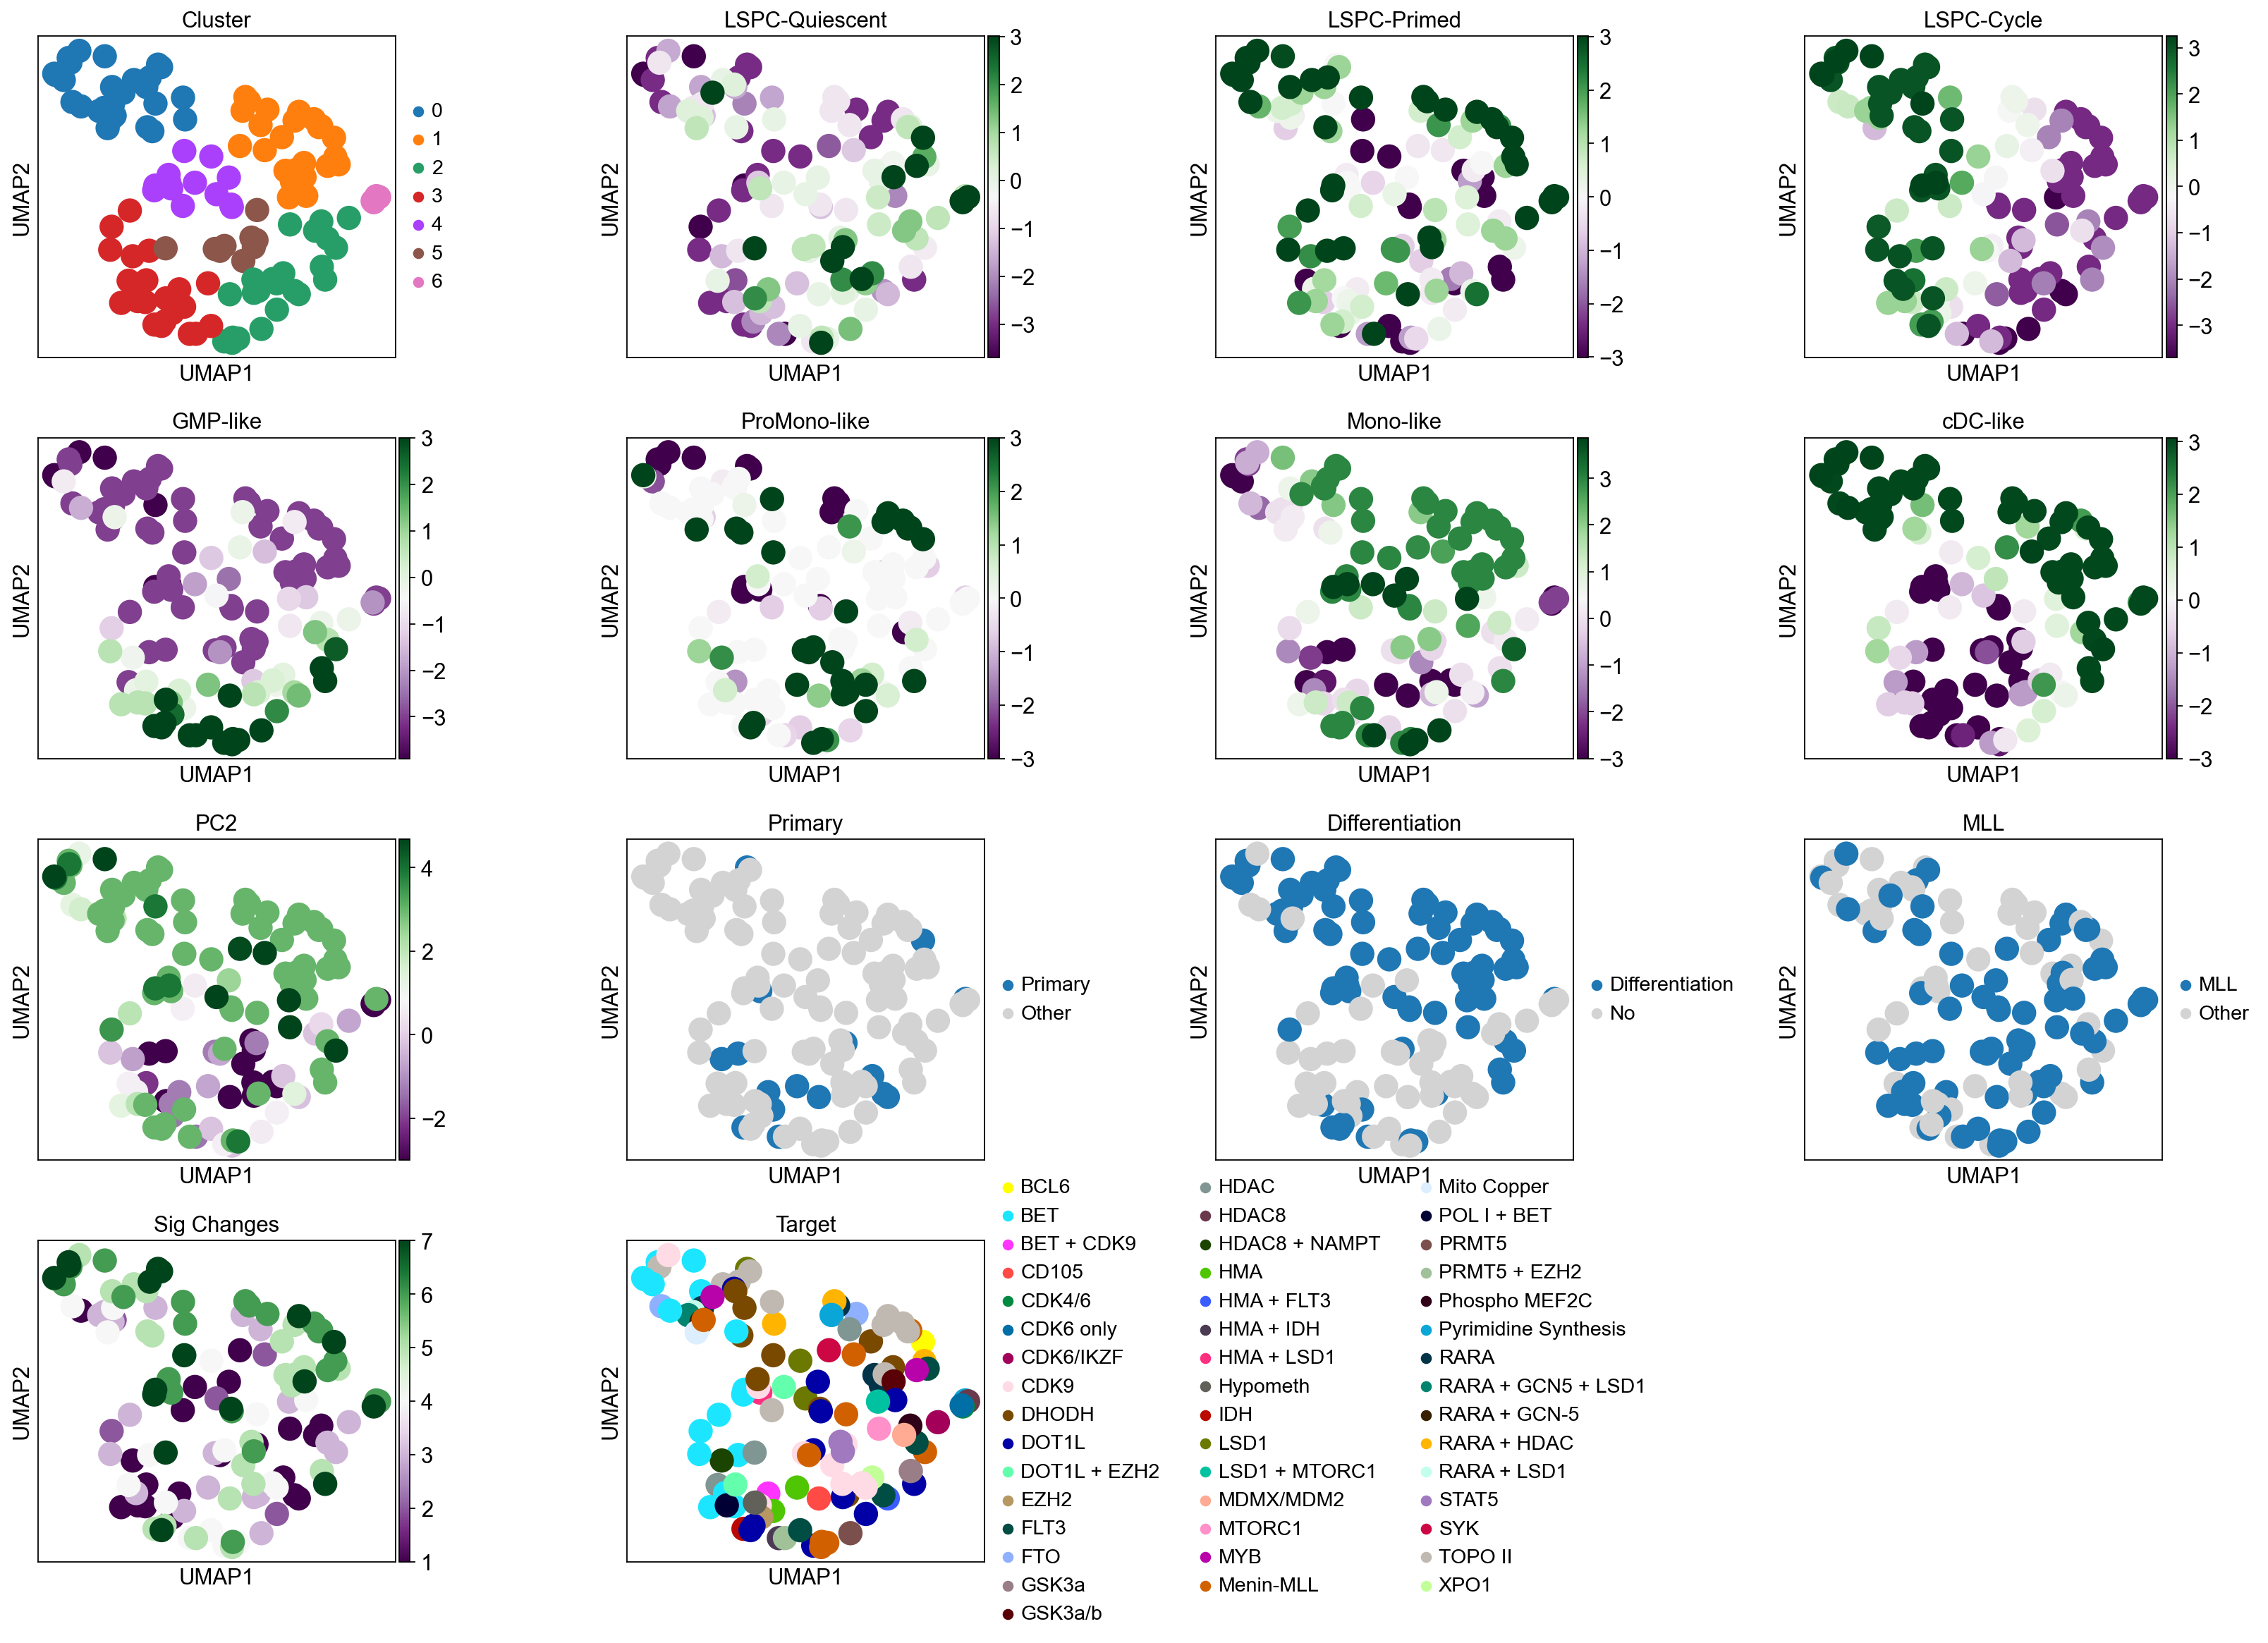

In [282]:
sc.pl.umap(composition, color=['Cluster', 'LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 
                               'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like', 
                               'PC2', 'Primary', 'Differentiation', 'MLL', 'Sig Changes', 'Target'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.5, ncols=4)

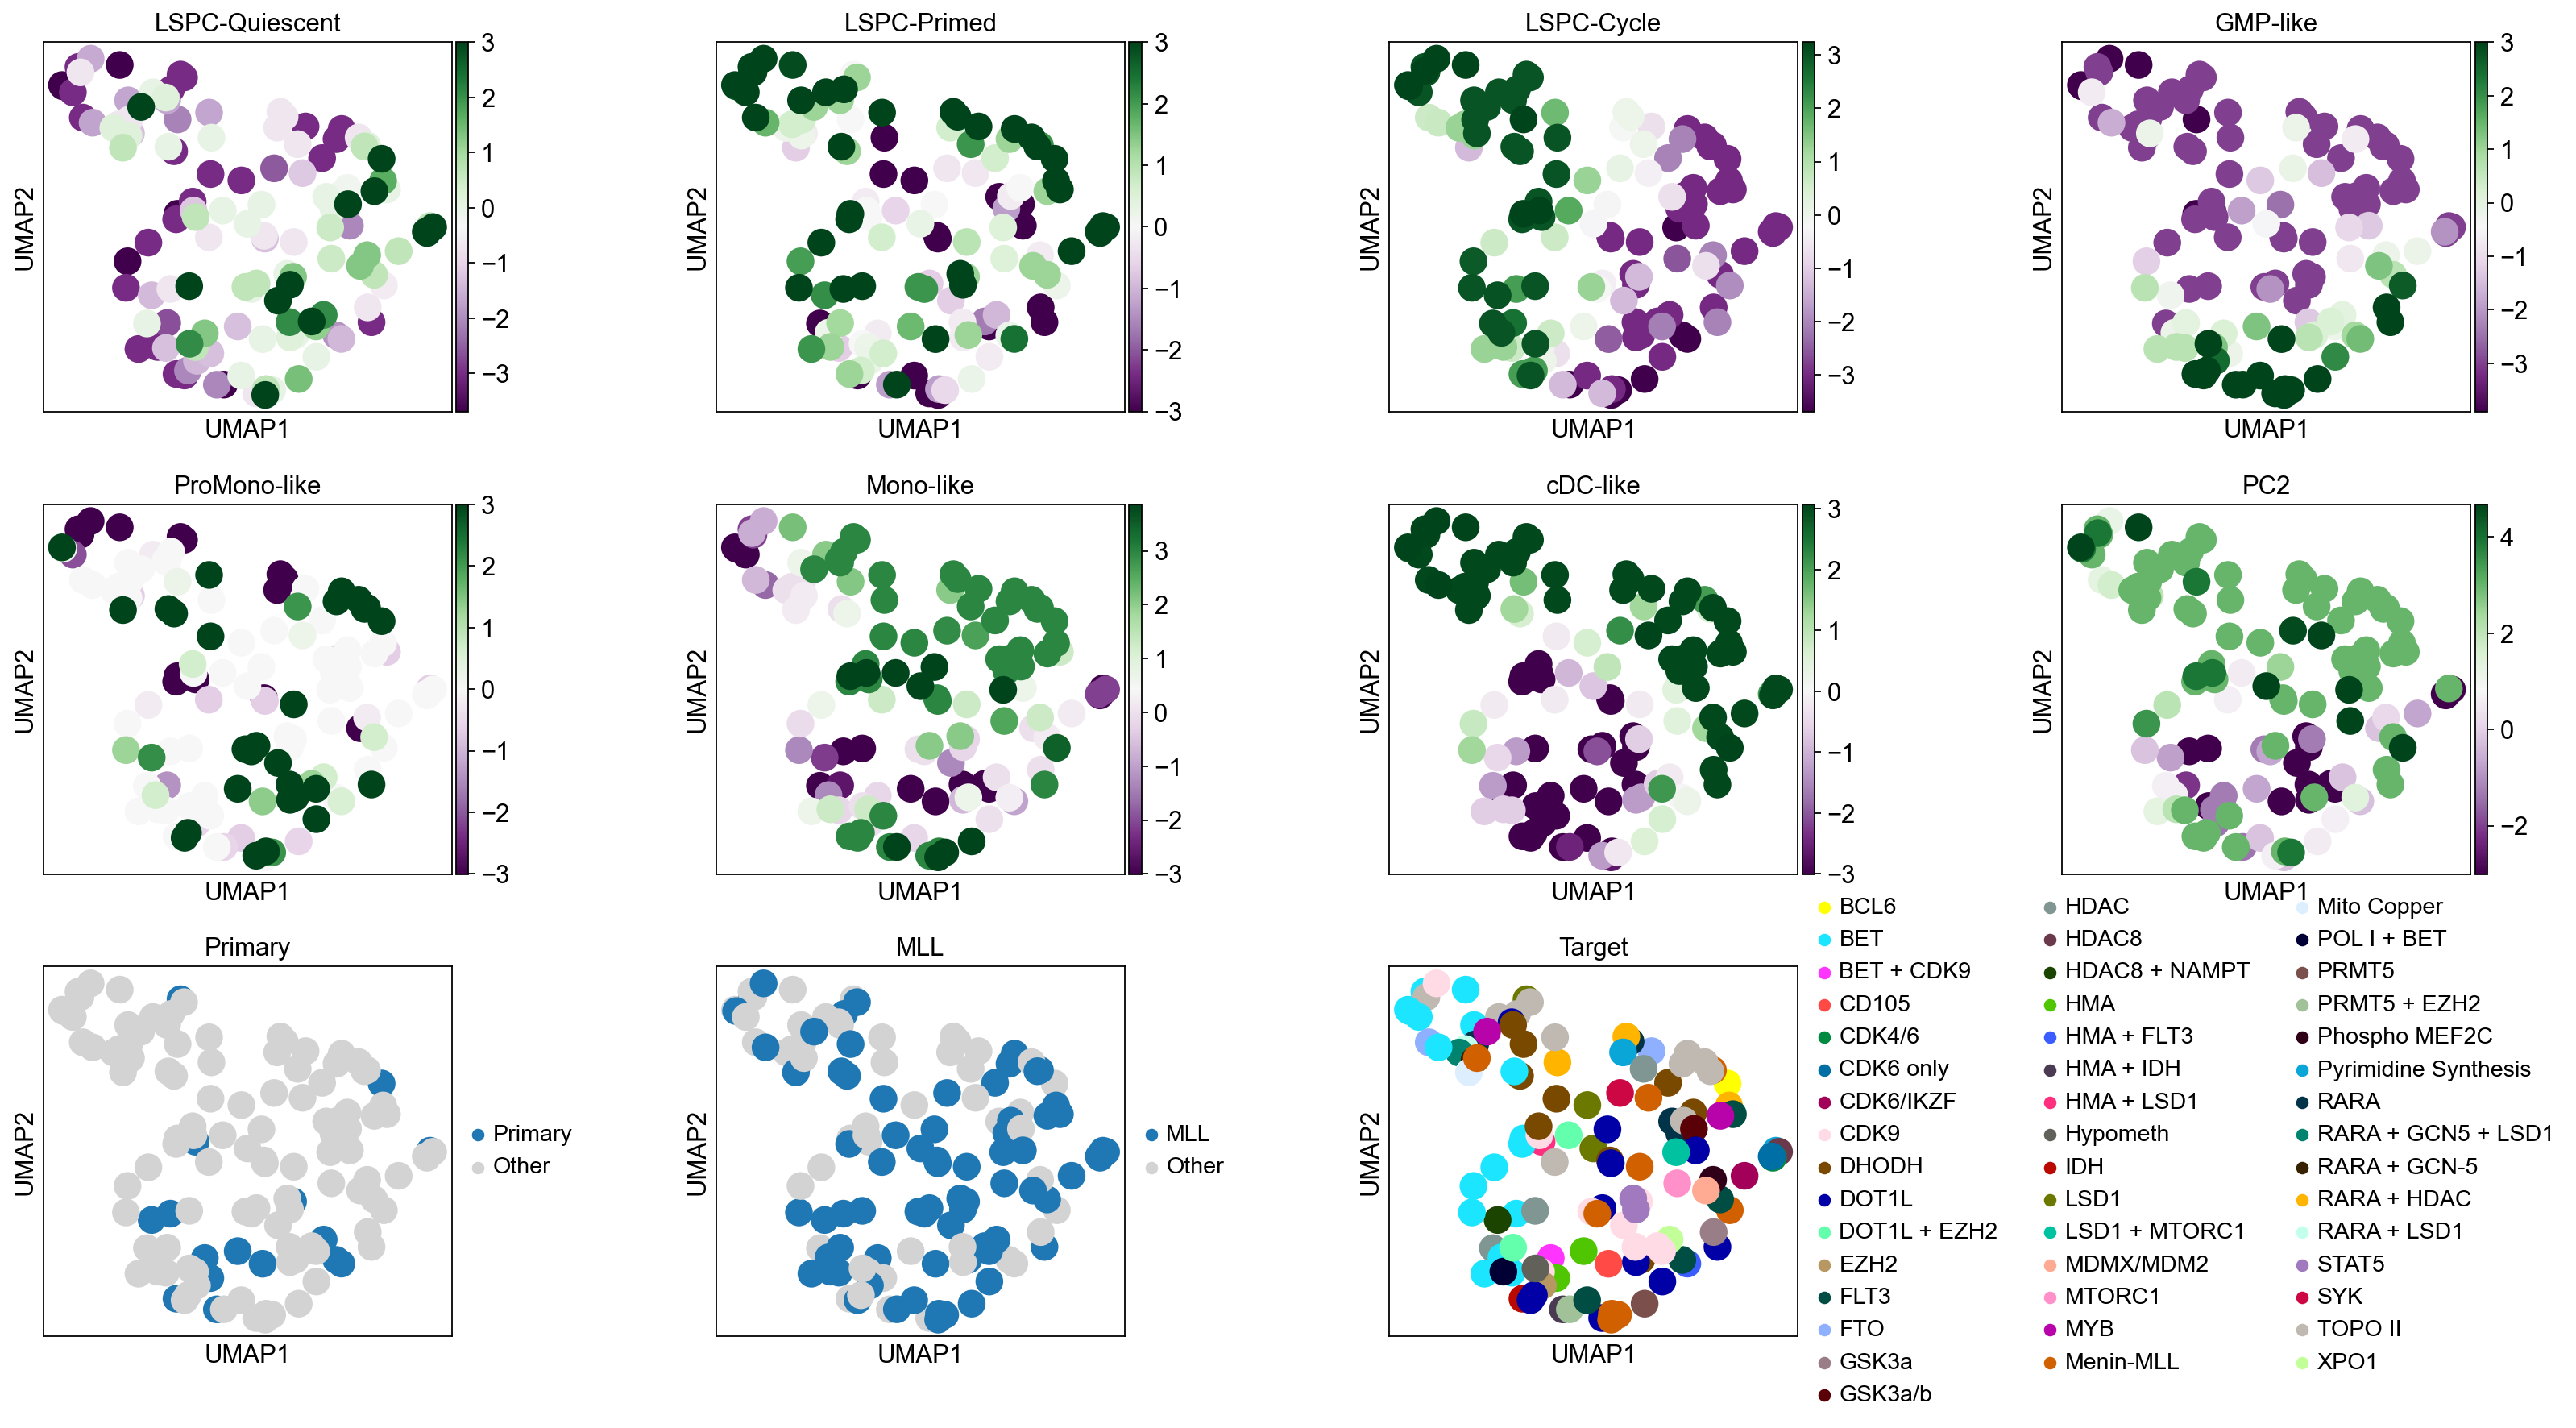

In [283]:
sc.pl.umap(composition, color=['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 
                               'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like', 
                               'PC2', 'Primary', 'MLL','Target'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.5, ncols=4, save = ".png")

### _Identify Clusters_

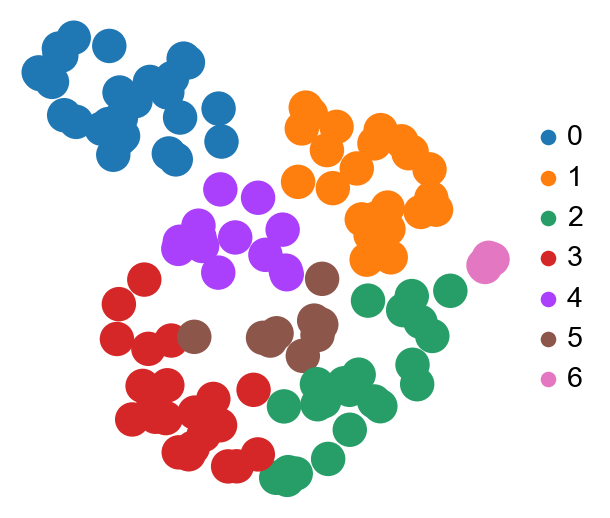

In [284]:
sc.pl.umap(composition, color=['Cluster'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.5, ncols=4, frameon = False, title='', save = "_clusters.png")

### _Measure Differentiation_

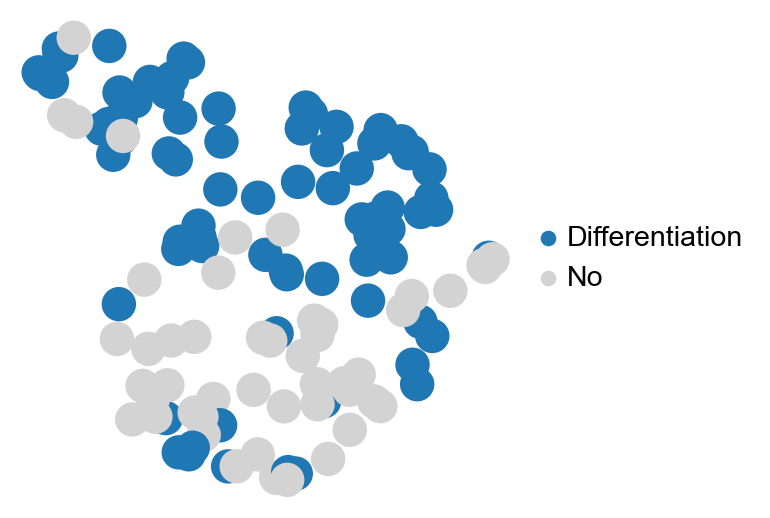

In [285]:
sc.pl.umap(composition, color=['Differentiation'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.5, ncols=4, frameon = False, title='', save = "_differentiation.png")

# Configure Drug Response Heatmap

***

Trying to set attribute `.obs` of view, copying.


Cluster). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


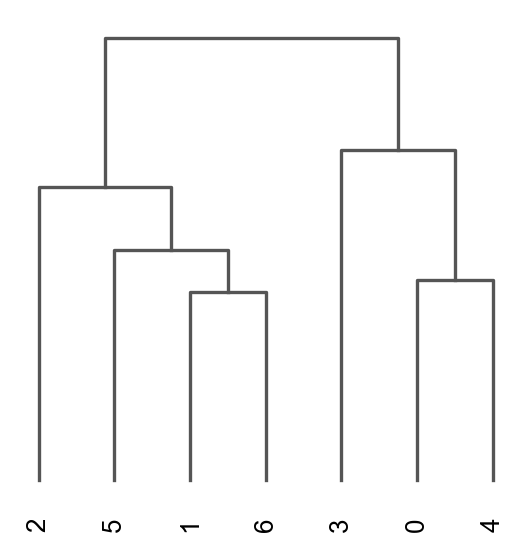

<AxesSubplot:>

In [286]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall.obs['\nCluster'] = composition.obs['leiden']

# Create dendrogram
sc.tl.dendrogram(compall, groupby = "\nCluster" )
sc.pl.dendrogram(compall, groupby = "\nCluster")

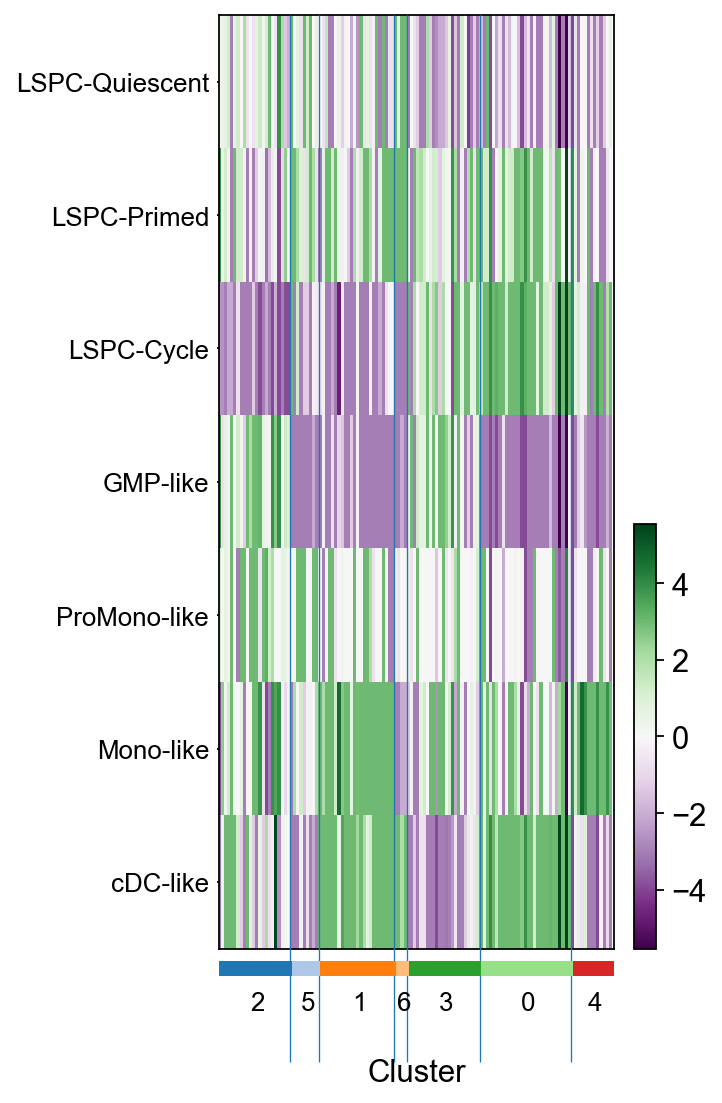

In [287]:
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['2', '5', '1', '6', '3', '0', '4'])
sc.pl.heatmap(compall, var_names = compall.var_names, groupby = "\nCluster", cmap = 'PRGn', figsize = [3.5,8], swap_axes = True, save = "_treatmentclusters.png")

# Highlight Specific Cases

***

### _Selinexor (XPO1 Inhibitor)_

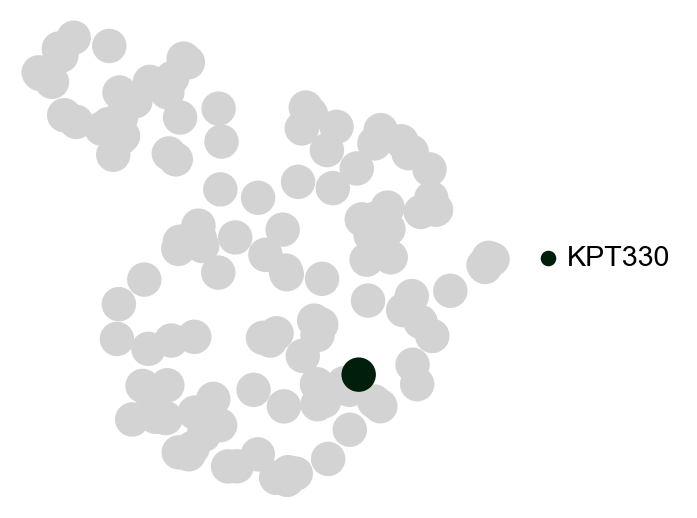

In [288]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['KPT330'], frameon = False, title = '', save = "_XPO1.png")

### _CDK 6 Inhibition_

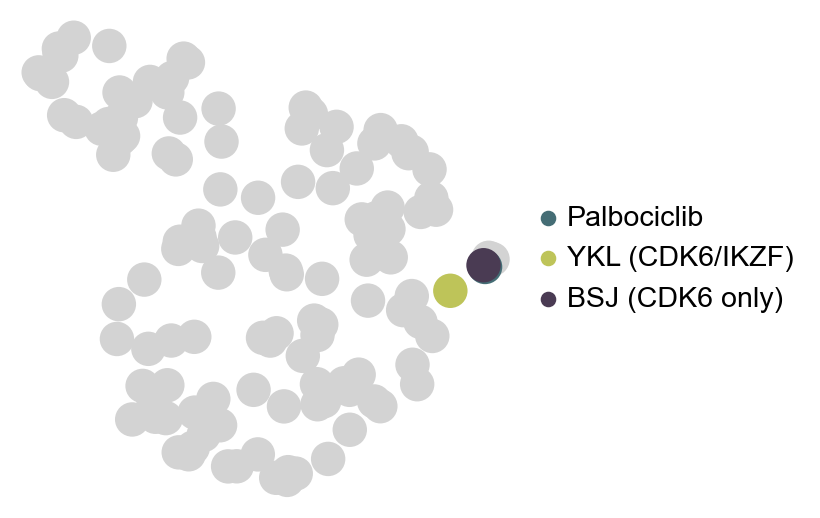

In [289]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['Palbociclib', 'YKL (CDK6/IKZF)', 'BSJ (CDK6 only)'], frameon = False, title = "", save = "_CDK6.png")

Trying to set attribute `.obs` of view, copying.


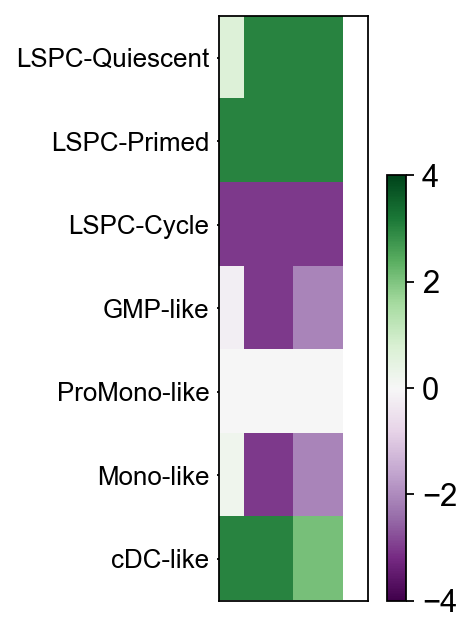

In [290]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['Palbociclib', 'YKL (CDK6/IKZF)', 'BSJ (CDK6 only)'])]
compall.obs['Cluster'] = composition.obs['leiden']
compall.obs['Cluster'] = compall.obs['Cluster'].cat.set_categories(['2, 6'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='Cluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_CDK6.png")

### _BET Inhibition_

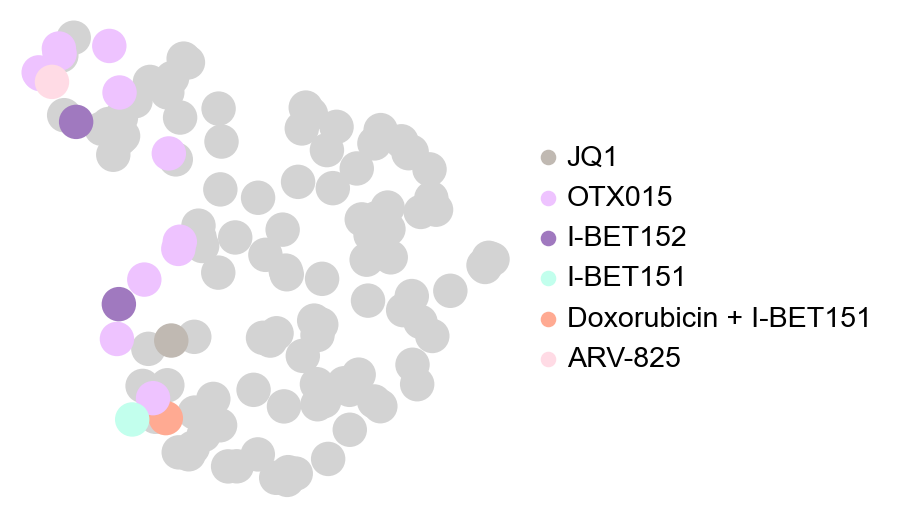

In [291]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['JQ1', 'OTX015', 'I-BET152', 'I-BET151', 'Doxorubicin + I-BET151', 'ARV-825'], frameon = False, title = '', save = "_BET.png")

Trying to set attribute `.obs` of view, copying.


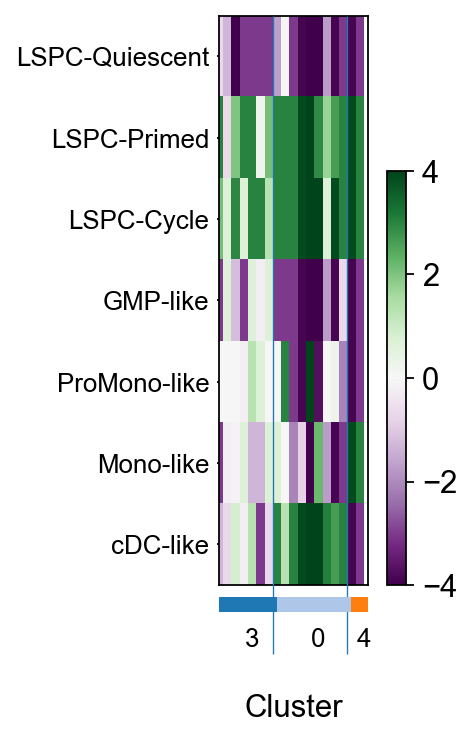

In [292]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['JQ1', 'OTX015', 'I-BET152', 'I-BET151', 'Doxorubicin + I-BET151', 'ARV-825'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['3', '0', '4'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_BET.png")

### _IDH Mutant AML_

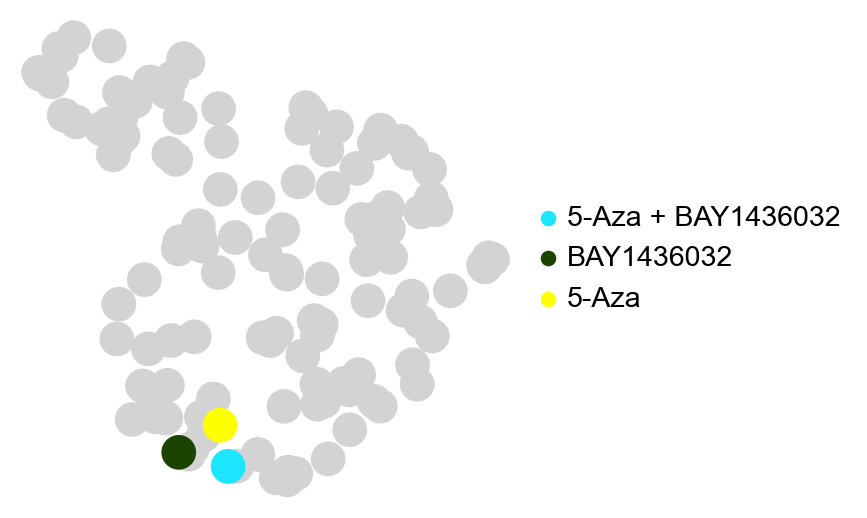

In [293]:
sc.pl.umap(composition[~composition.obs.index.isin(["5-Aza [TET2mut]", "5-Aza [OCI-AML3]"])], color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['5-Aza + BAY1436032', 'BAY1436032', '5-Aza'], frameon = False, title = '', save = "_IDH.png")

Trying to set attribute `.obs` of view, copying.


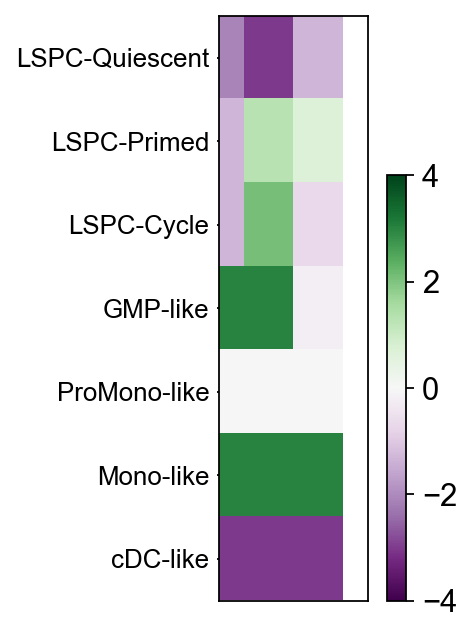

In [294]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['5-Aza + BAY1436032', 'BAY1436032', '5-Aza'])]
compall = compall[~compall.obs.index.isin(["5-Aza [TET2mut]", "5-Aza [OCI-AML3]"])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['3'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_IDH.png")

### _Menin MLL Inhibition_

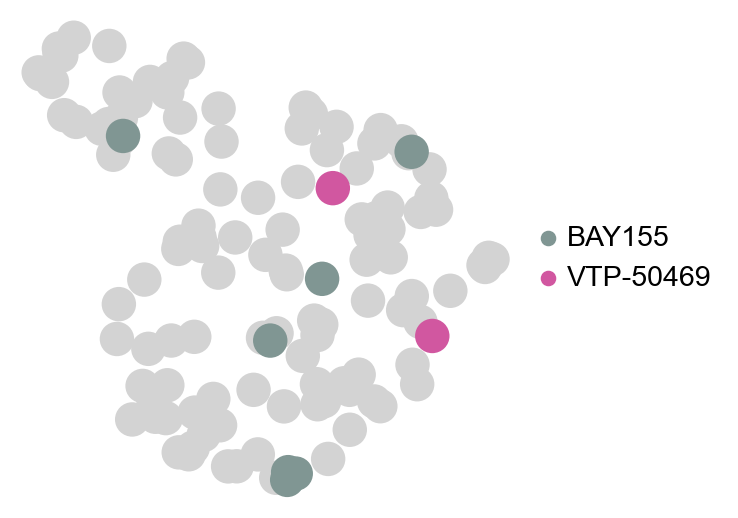

In [295]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['BAY155', 'VTP-50469'], frameon = False, title = '', save = "_MeninMLL.png")

Trying to set attribute `.obs` of view, copying.


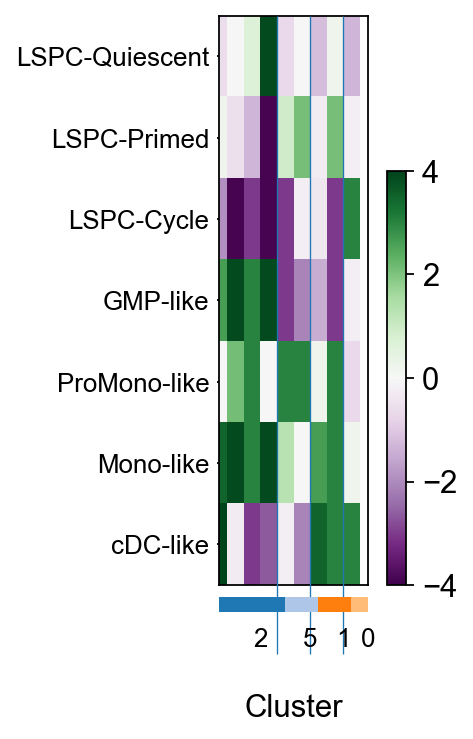

In [296]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['BAY155', 'VTP-50469'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['2', '5', '1', '0'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_MeninMLL.png")

### _ATRA vs Brequinar_

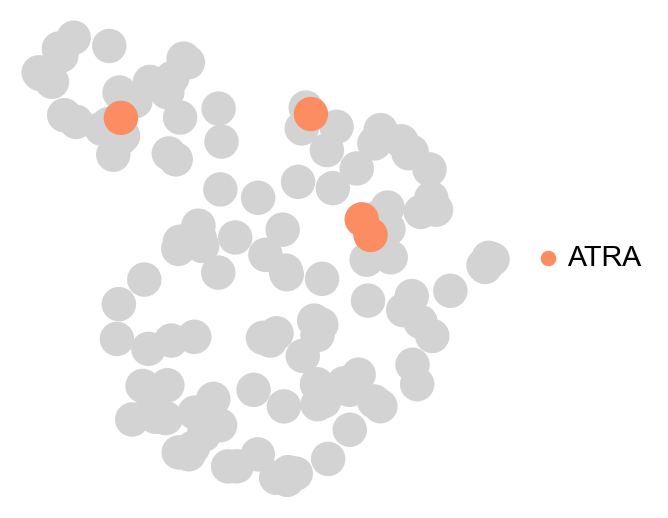

In [297]:
sc.pl.umap(composition, palette = "Set2", color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['ATRA'], frameon = False, title = '', save = "_ATRA.png")

Trying to set attribute `.obs` of view, copying.


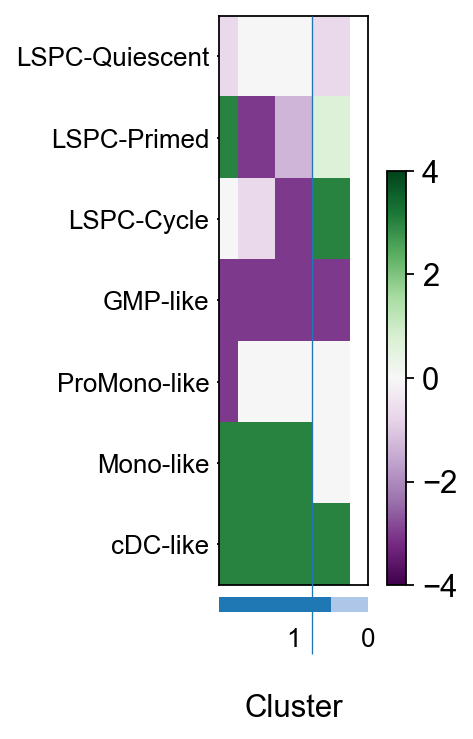

In [298]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['ATRA'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['1', '0'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_ATRA.png")

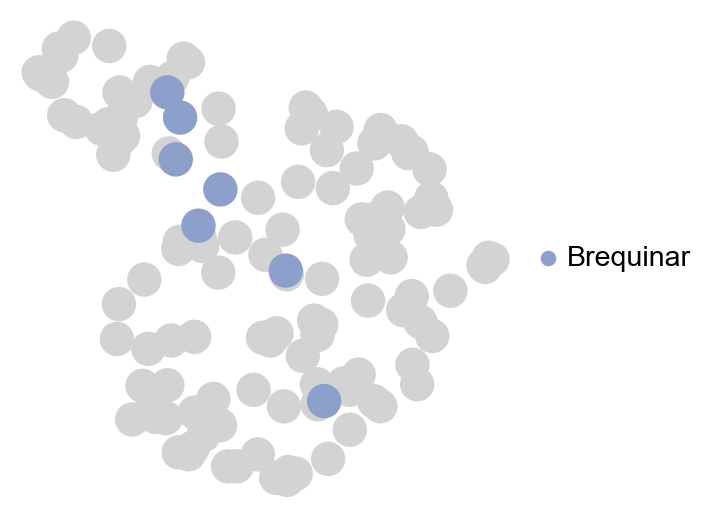

In [299]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['Brequinar'], frameon = False, title = '', save = "_Brequinar.png")

Trying to set attribute `.obs` of view, copying.


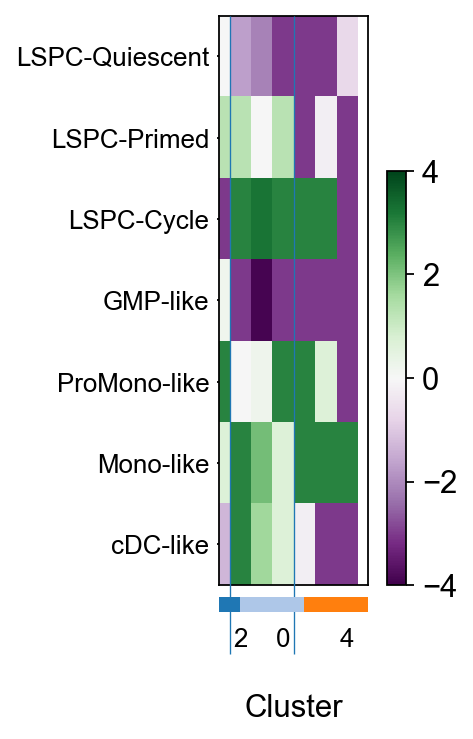

In [300]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['Brequinar'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['2', '0', '4'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_Brequinar.png")

### _DOT1L Inhibition_

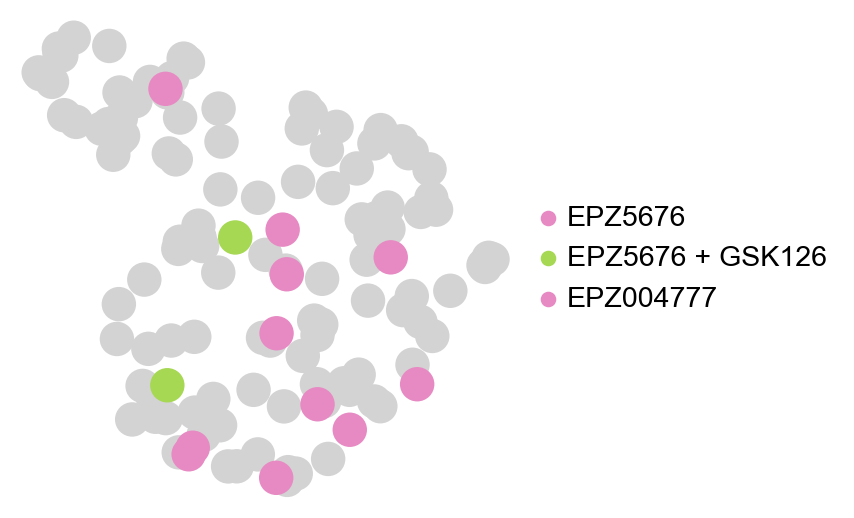

In [301]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['EPZ5676', 'EPZ5676 + GSK126', 'EPZ004777'], frameon = False, title = '', save = "_DOT1L.png")

Trying to set attribute `.obs` of view, copying.


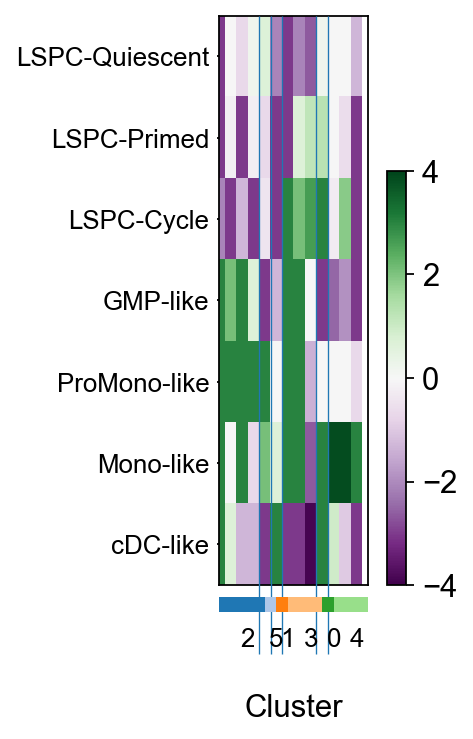

In [302]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['EPZ5676', 'EPZ5676 + GSK126', 'EPZ004777'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['2', '5', '1', '3', '0', '4'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_DOT1L.png")

### _DHODH Inhibition_

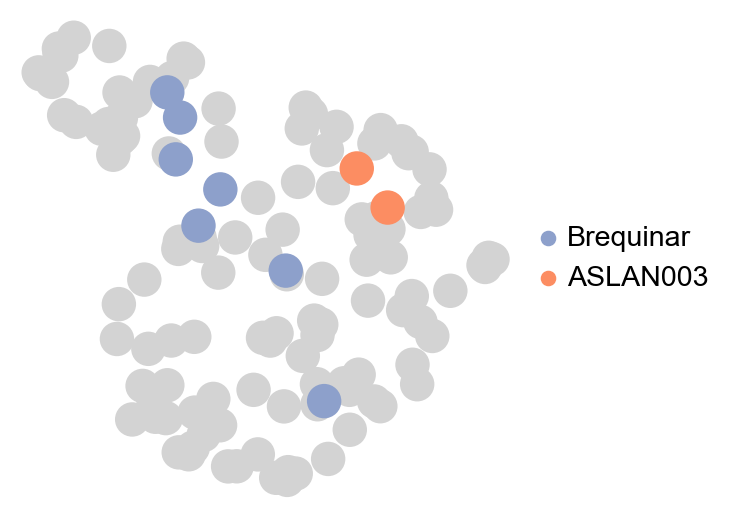

In [303]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['Brequinar', 'ASLAN003'], frameon = False, title = '', save = "_DHODH.png")

Trying to set attribute `.obs` of view, copying.


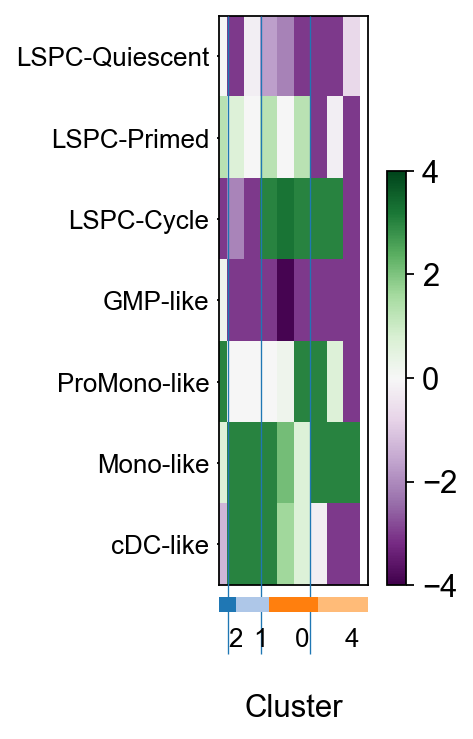

In [304]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['Brequinar', 'ASLAN003'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['2', '1', '0', '4'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_DHODH.png")

### _TOPO II Inhibition_

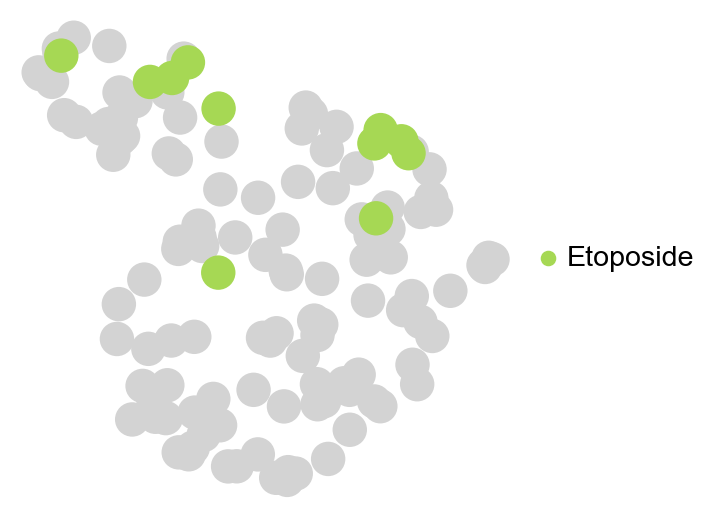

In [305]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['Etoposide'], frameon = False, title = '', save = "_TOPOII.png")

Trying to set attribute `.obs` of view, copying.


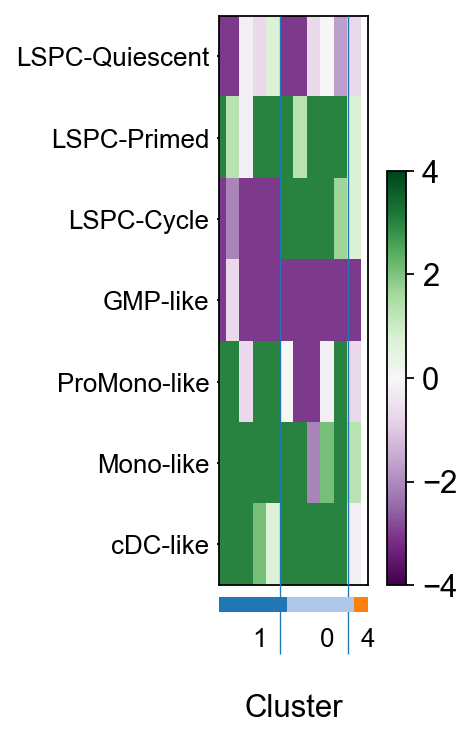

In [306]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['Etoposide'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['1', '0', '4'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_TOPOII.png")

### _HDAC Inhibition_

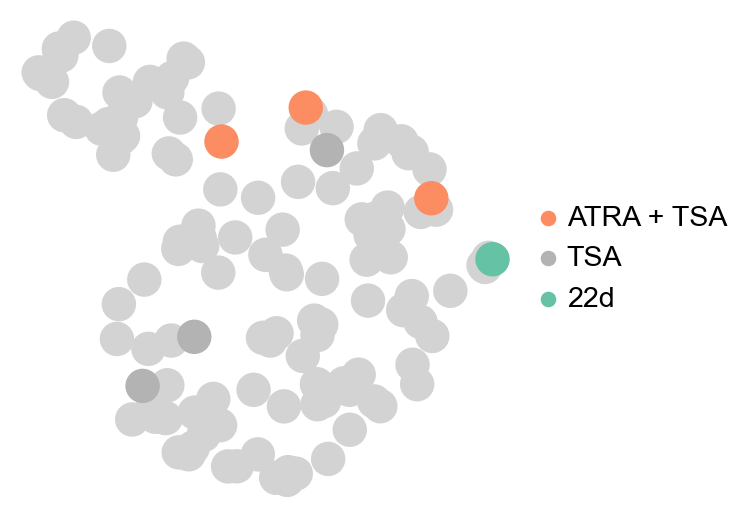

In [307]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['ATRA + TSA', 'TSA', '22d'], frameon = False, title = '', save = "_HDAC.png")

Trying to set attribute `.obs` of view, copying.


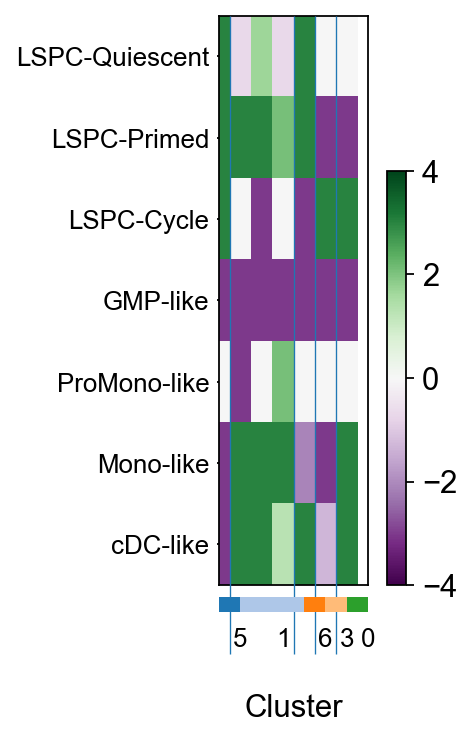

In [308]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['ATRA + TSA', 'TSA', '22d'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['5', '1', '6', '3', '0'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_HDAC.png")

### _LSD1 Inhibition_

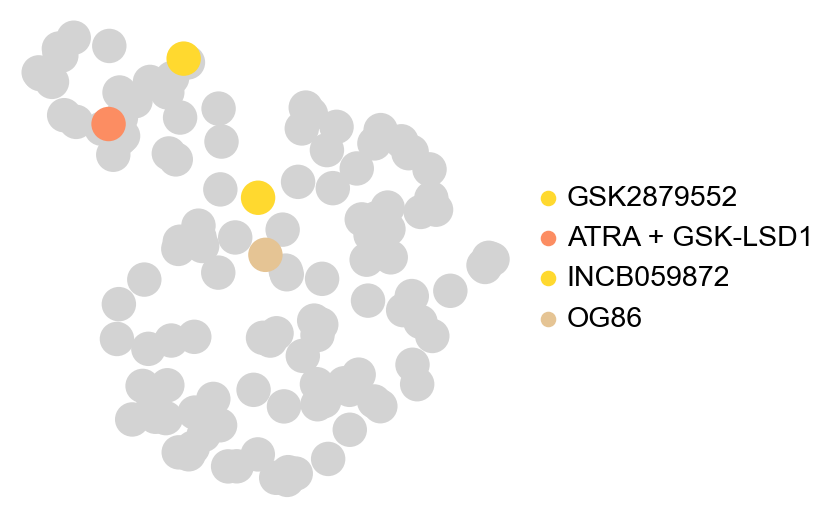

In [309]:
sc.pl.umap(composition, color=['Drug'], cmap='PRGn', vmin='p5', vmax='p95', wspace=0.4, ncols=4, groups=['GSK2879552','ATRA + GSK-LSD1', 'INCB059872', 'OG86'], frameon = False, title = '', save = "_LSD1.png")

Trying to set attribute `.obs` of view, copying.


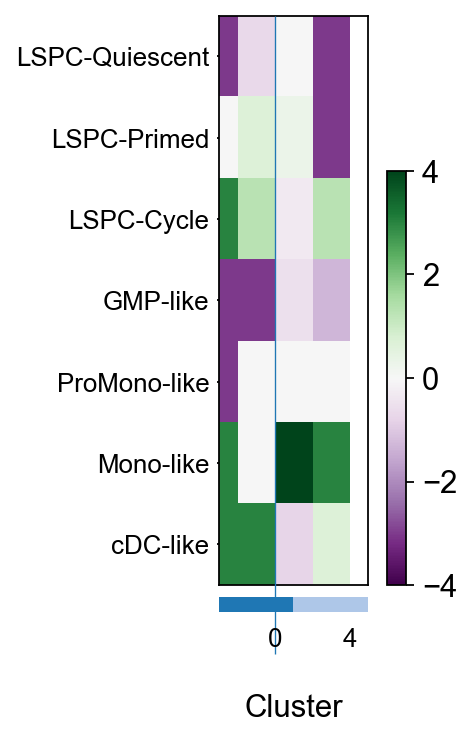

In [310]:
compall = ad.AnnData(cat_logpval_dir.T.iloc[:,0:7])
compall = compall[compall.to_df().index.isin(composition.to_df().index)]
compall = compall[composition.obs.Drug.isin(['GSK2879552','ATRA + GSK-LSD1', 'INCB059872', 'OG86'])]
compall.obs['\nCluster'] = composition.obs['leiden']
compall.obs['\nCluster'] = compall.obs['\nCluster'].cat.set_categories(['0', '4'])
sc.pl.heatmap(compall, var_names=compall.var_names, groupby='\nCluster', swap_axes=True, cmap='PRGn', figsize=[1.5,5], dendrogram=False, vmin = -4, vmax = 4, save = "_LSD1.png")

# Create Annotations

In [311]:
annotations = composition.obs[['Cohort', 'Drug', 'Target', 'Genomics', 'Differentiation', 'PC2', 'Primary', 'leiden']]

In [312]:
annotations = annotations.sort_index(key=lambda x: x.str.lower())

In [313]:
annotations.to_csv("annotations.csv")
annotations.to_csv('C:/Users/Hp/Desktop/AML-drug-response/Complex Heatmap/Data/annotations.csv')

## Export Examples for Complex Heatmap

In [314]:
CDK6 = composition[composition.obs.Drug.isin(['Palbociclib', 'YKL (CDK6/IKZF)', 'BSJ (CDK6 only)'])].to_df()
IDH = composition[composition.obs.Drug.isin(['5-Aza + BAY1436032', 'BAY1436032', '5-Aza'])].to_df()
IDH = IDH[~IDH.index.isin(["5-Aza [TET2mut]", "5-Aza [OCI-AML3]"])]
ATRA = composition[composition.obs.Drug.isin(['ATRA'])].to_df()
Brequinar = composition[composition.obs.Drug.isin(['Brequinar'])].to_df()

In [315]:
CDK6.to_csv("CDK6.csv")
IDH.to_csv("IDH.csv")
ATRA.to_csv("ATRA.csv")
Brequinar.to_csv("Brequinar.csv")

In [316]:
C0 = composition[composition.obs.Cluster.isin(["0"])].to_df()
C0.to_csv("Cluster0.csv")

C1 = composition[composition.obs.Cluster.isin(["1"])].to_df()
C1.to_csv("Cluster1.csv")

C2 = composition[composition.obs.Cluster.isin(["2"])].to_df()
C2.to_csv("Cluster2.csv")

C3 = composition[composition.obs.Cluster.isin(["3"])].to_df()
C3.to_csv("Cluster3.csv")

C4 = composition[composition.obs.Cluster.isin(["4"])].to_df()
C4.to_csv("Cluster4.csv")

C5 = composition[composition.obs.Cluster.isin(["5"])].to_df()
C5.to_csv("Cluster5.csv")

C6 = composition[composition.obs.Cluster.isin(["6"])].to_df()
C6.to_csv("Cluster6.csv")

## Treatment Clusters Summary

In [317]:
treatment_condition = composition.obs[["Drug", "Cohort"]]
treatment_scores = composition.to_df()
treatment_info = composition.obs[["PC2", "Cluster"]]
treatment_summary = pd.concat([treatment_condition, treatment_scores, treatment_info], axis = 1)
treatment_summary["Umap X"] = composition.obsm["X_umap"][:, 0]
treatment_summary["Umap Y"] = composition.obsm["X_umap"][:, 1]
treatment_summary.to_csv("treatment_summary.csv")